<a href="https://colab.research.google.com/github/amkayhani/FAIDM/blob/main/Explainability_LIME_SHAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Explainability in Machine Learning: LIME & SHAP (Beginner-Friendly)

**Notebook goal:** help you understand *why* a model makes a prediction, using two popular, model-agnostic approaches:
- **LIME** (Local Interpretable Model-agnostic Explanations)
- **SHAP** (SHapley Additive exPlanations)

This notebook is designed for students with **no prior background** in explainability. It mixes clear explanations with hands-on code.

---

## What you’ll learn

By the end, you should be able to:

1. Explain what *model explainability* is and why it matters (trust, debugging, fairness, regulation).
2. Distinguish **global** vs **local** explanations.
3. Use **LIME** to explain an individual prediction.
4. Use **SHAP** to produce both global and local explanations.
5. Compare LIME vs SHAP and recognise their **pitfalls** and **best practices**.
6. Tackle exercises to check understanding.

---

## How to use this notebook

- Run cells top-to-bottom.
- Read the markdown carefully: it explains *what* you’re doing and *why*.
- Most plots are visual explanations (don’t skip them!).

> **Important:** Explanations are not “truth”. They are *tools* that can help you reason about a model, but they can also mislead if used carelessly.

---

**Last updated:** 2026-01-28


## Table of contents

1. [What is explainability?](#what-is-explainability)
2. [Global vs local explanations](#global-vs-local-explanations)
3. [Our running example dataset + model](#running-example)
4. [Baseline evaluation](#baseline-evaluation)
5. [A simple global baseline: permutation importance](#permutation-importance)
6. [LIME: local explanations](#lime)
7. [SHAP: Shapley-value explanations](#shap)
8. [LIME vs SHAP](#lime-vs-shap)
9. [Pitfalls & good practice](#pitfalls)
10. [Exercises](#exercises)
11. [Mini-project (optional): regression example](#mini-project)


<a id="what-is-explainability"></a>
## 1) What is explainability?

Modern ML models can be very accurate, but often feel like a **black box**: you give inputs, you get predictions, but you don’t know *why*.

**Explainability** is about producing *human-understandable reasons* for a model’s behaviour.

### Why do we care?

- **Trust:** would you act on a prediction without knowing why?
- **Debugging:** explanations can reveal leakage, spurious correlations, or data errors.
- **Fairness / bias:** are sensitive or proxy features driving outcomes?
- **Safety:** do predictions behave sensibly when inputs change?
- **Regulation and governance:** some domains require transparency.

### A key idea: “What is the explanation *for*?”

Different audiences need different explanations:
- A clinician might want medically plausible reasons.
- A data scientist might want to diagnose feature leakage.
- A regulator might want proof of non-discrimination.

So there isn’t a single “best” explanation — there are trade-offs.


<a id="global-vs-local-explanations"></a>
## 2) Global vs local explanations

### Global explanations (whole model)
These describe patterns across many predictions:
- Which features matter most *overall*?
- What features tend to push predictions up or down?
- Does the model behave reasonably across ranges of input?

### Local explanations (one prediction)
These describe why the model predicted something for a specific case:
- Why did *this* person get classified as high-risk?
- Which features pushed the model towards class A vs class B?

### Another important distinction
**Intrinsic interpretability** vs **post-hoc explainability**:

- *Intrinsic interpretability:* the model is simple enough to understand directly (e.g., small decision tree, linear regression).
- *Post-hoc explainability:* the model is complex, and we add an explanation method on top (e.g., LIME, SHAP).

In this notebook we focus on **post-hoc, model-agnostic** methods: LIME and SHAP.


<a id="running-example"></a>
## 3) Running example: dataset + model

We’ll use the classic **Breast Cancer Wisconsin** dataset from scikit-learn.  
Goal: predict whether a tumour is **malignant** or **benign** based on measured features.

We’ll train a **Random Forest classifier**. Why random forest?
- Decently accurate out of the box
- Works well on tabular data
- SHAP has efficient support for tree-based models
- LIME can explain any classifier that provides probabilities

> Note: This dataset is widely used for teaching. In real clinical settings, you’d need domain-specific validation and careful governance.


In [1]:
# Install dependencies (Colab-friendly)
# If you are running locally, you may already have these.
!pip -q install shap lime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance

import shap
from lime.lime_tabular import LimeTabularExplainer

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [2]:
# Load data
data = load_breast_cancer(as_frame=True)
X = data.frame.drop(columns=["target"])
y = data.target

feature_names = X.columns.tolist()
class_names = [str(c) for c in data.target_names]  # typically ['malignant', 'benign']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    stratify=y,
    random_state=RANDOM_STATE
)

X_train.shape, X_test.shape


((426, 30), (143, 30))

In [3]:
# Train a Random Forest
rf = RandomForestClassifier(
    n_estimators=400,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# Predict
pred = rf.predict(X_test)
proba = rf.predict_proba(X_test)[:, 1]  # probability of class 1


<a id="baseline-evaluation"></a>
## 4) Baseline evaluation

Before explaining a model, always check its basic performance.

We’ll look at:
- **Accuracy** (fraction correctly classified)
- **ROC AUC** (how well probabilities rank positive cases)
- Confusion matrix + classification report

> Explainability doesn’t rescue a bad model. If the model is unreliable, explanations just help you understand *unreliable behaviour*.


Accuracy: 0.958
ROC AUC:  0.994

Classification report:
              precision    recall  f1-score   support

   malignant       0.96      0.92      0.94        53
      benign       0.96      0.98      0.97        90

    accuracy                           0.96       143
   macro avg       0.96      0.95      0.95       143
weighted avg       0.96      0.96      0.96       143



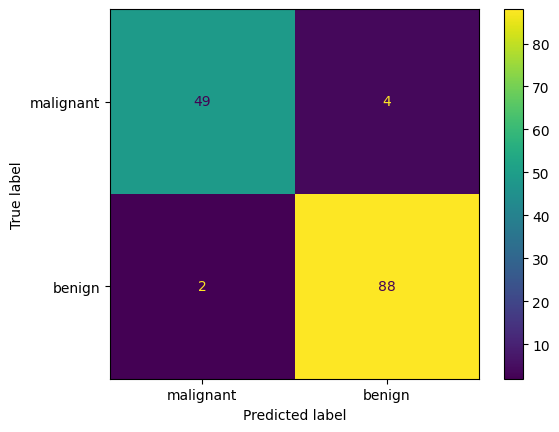

In [4]:
acc = accuracy_score(y_test, pred)
auc = roc_auc_score(y_test, proba)

print(f"Accuracy: {acc:.3f}")
print(f"ROC AUC:  {auc:.3f}\n")

print("Classification report:")
print(classification_report(y_test, pred, target_names=class_names))

ConfusionMatrixDisplay.from_predictions(y_test, pred, display_labels=class_names)
plt.show()


<a id="permutation-importance"></a>
## 5) A simple global baseline: permutation importance

Before jumping to LIME/SHAP, it’s useful to learn a simple global method:

### Permutation importance (global)
Idea:
1. Measure performance normally.
2. For one feature at a time: **shuffle that column** (break its relationship with the target).
3. Measure how much performance drops.
4. Bigger drop ⇒ feature was more important for the model.

Pros:
- Model-agnostic
- Easy to explain

Cons (important!):
- If features are **correlated**, shuffling one may not hurt much because the model can use correlated alternatives.
- It can be slow if you have many features and a large dataset.


In [5]:
perm = permutation_importance(
    rf, X_test, y_test,
    n_repeats=15,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    scoring="roc_auc"
)

imp = pd.DataFrame({
    "feature": feature_names,
    "importance_mean": perm.importances_mean,
    "importance_std": perm.importances_std
}).sort_values("importance_mean", ascending=False)

imp.head(10)


,feature,importance_mean,importance_std
23,worst area,0.004787,0.002717
27,worst concave points,0.003983,0.002162
22,worst perimeter,0.003208,0.002405
7,mean concave points,0.002187,0.001412
21,worst texture,0.001398,0.000760
1,mean texture,0.000804,0.000552
26,worst concavity,0.000636,0.000709
6,mean concavity,0.000538,0.000610
24,worst smoothness,0.000503,0.000499
15,compactness error,0.000300,0.000284


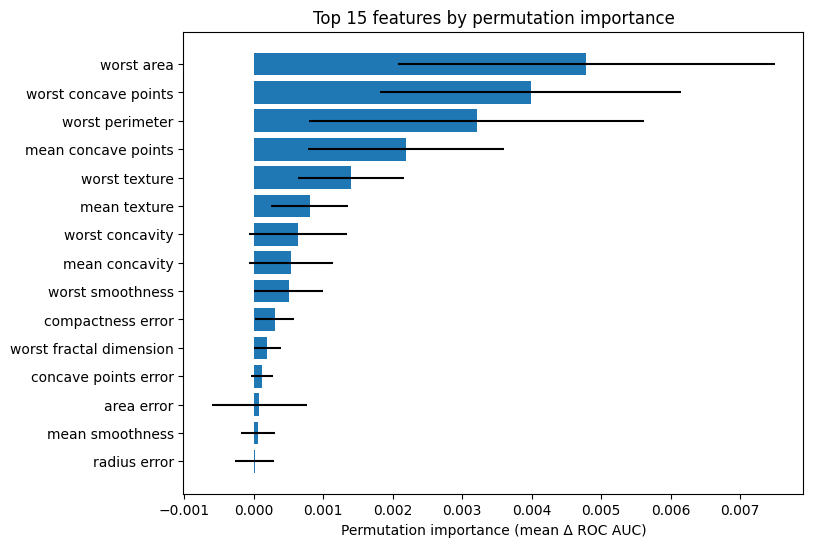

In [6]:
# Plot top 15 permutation importances
top_k = 15
plot_df = imp.head(top_k).iloc[::-1]  # reverse for nicer bar plot

plt.figure(figsize=(8, 6))
plt.barh(plot_df["feature"], plot_df["importance_mean"], xerr=plot_df["importance_std"])
plt.xlabel("Permutation importance (mean Δ ROC AUC)")
plt.title(f"Top {top_k} features by permutation importance")
plt.show()


Now we’ll move from a **global baseline** to **local explanations**: explaining *one* prediction at a time.

That’s where LIME and SHAP shine.


<a id="lime"></a>
## 6) LIME (Local Interpretable Model-agnostic Explanations)

### Intuition
LIME answers:

> “What simple, interpretable model behaves like my complicated model **near this one example**?”

LIME builds a **local surrogate model** (often linear) around a single instance:

1. Pick the instance you want to explain: \(x\)
2. Create many “perturbed” samples around \(x\) (slightly changed versions)
3. Ask the black-box model for predictions on those samples
4. Weight samples by how close they are to \(x\)
5. Fit a simple model (e.g., linear regression/classifier) to approximate the black box locally
6. Use the surrogate’s coefficients as the explanation

### What you get
A list like:
- Feature A increases the prediction
- Feature B decreases the prediction
…for this specific instance.

### What to remember
- LIME is **local**, not global.
- Explanations can vary with randomness (sampling).
- Explanations depend on how “neighbourhood” and “similarity” are defined.


In [7]:
# Build a LIME explainer for tabular classification

lime_explainer = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=feature_names,
    class_names=class_names,
    mode="classification",
    discretize_continuous=True,  # bins continuous features for interpretability
    random_state=RANDOM_STATE
)

# Choose an instance to explain
idx = 1
x0 = X_test.iloc[idx].values

# Explain prediction
lime_exp = lime_explainer.explain_instance(
    data_row=x0,
    predict_fn=rf.predict_proba,
    num_features=10,   # show top 10 features
    num_samples=2000   # how many perturbations to generate
)

print("Model predicted probabilities:", rf.predict_proba([x0])[0])
print("\nLIME explanation (feature, contribution):")
for feat, weight in lime_exp.as_list():
    print(f"{feat:40s}  {weight:+.4f}")


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Model predicted probabilities: [1. 0.]

LIME explanation (feature, contribution):
worst area > 1034.25                      -0.1431
worst concave points > 0.16               -0.1092
worst perimeter > 124.97                  -0.1063
worst radius > 18.55                      -0.0954
mean concave points > 0.07                -0.0766
area error > 45.13                        -0.0656
mean area > 765.38                        -0.0482
mean perimeter > 103.67                   -0.0457
mean radius > 15.75                       -0.0395
worst compactness > 0.34                  -0.0167


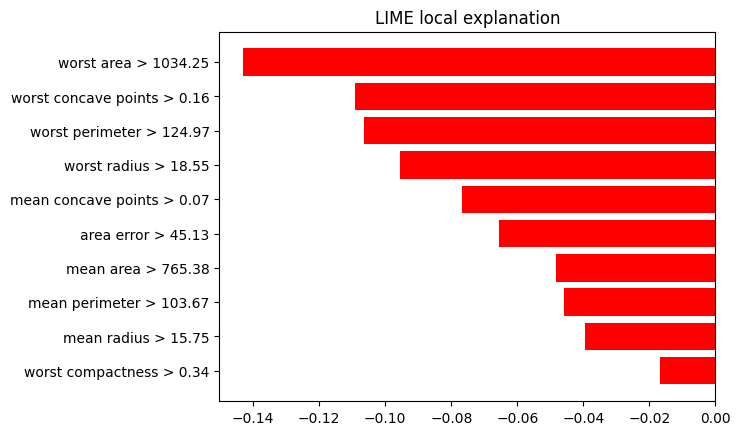

In [8]:
# Visualise LIME explanation as a plot
fig = lime_exp.as_pyplot_figure()
plt.title("LIME local explanation")
plt.show()


### Interpreting the LIME output

- Positive weights push towards one class, negative weights push towards the other.
- The explanation is only intended to be reliable **near the explained point**.
- If you change `num_samples` or the random seed, the explanation may change.

Try re-running the cells above with:
- different `idx`
- different `num_samples` (e.g., 1000 vs 10000)
- different `num_features`

This gives intuition about **stability** (a key concern with LIME).


<a id="shap"></a>
## 7) SHAP (SHapley Additive exPlanations)

SHAP is built on a game-theory idea called **Shapley values**.

### The core question SHAP answers

> “How should we fairly attribute the prediction to each feature?”

Imagine a prediction is a “payout” in a cooperative game, and each feature is a “player”.
Shapley values fairly assign credit to each player based on how much they contribute, *averaged over all possible feature orderings*.

### Why SHAP is popular
It has strong theoretical properties (under the Shapley framework):

- **Additivity / local accuracy:** feature contributions sum to the model output (up to a baseline).
- **Symmetry:** if two features contribute equally, they get equal credit.
- **Missingness (dummy):** a feature that never changes the prediction gets zero credit.
- **Consistency (for certain SHAP variants):** if a feature becomes more important in the model, its SHAP value should not decrease.

### Important practical note
SHAP values depend on:
- the **background / reference** data you choose (what counts as “missing”?)
- correlations between features
- the model class and SHAP algorithm used

For tree models (like random forests), SHAP can be computed efficiently.


In [9]:
# SHAP set-up
# Using a smaller background sample keeps things fast while remaining meaningful.
background = shap.sample(X_train, 200, random_state=RANDOM_STATE)

# TreeExplainer is fast for tree-based models
explainer = shap.TreeExplainer(rf, data=background)

# Compute SHAP values for the test set (may take a few seconds)
shap_values = explainer(X_test)

type(shap_values), getattr(shap_values, "values", None).shape


(shap._explanation.Explanation, (143, 30, 2))

### Handling binary classification output shapes

Depending on SHAP version and settings, you may see:
- values shaped like `(n_samples, n_features)` (single output)
- values shaped like `(n_samples, n_features, n_outputs)` (e.g., per class)

We’ll extract SHAP values for the “positive” class (index 1) if needed.


In [10]:
sv = shap_values

if sv.values.ndim == 3:
    # (n_samples, n_features, n_outputs)
    sv_pos = sv[:, :, 1]
else:
    sv_pos = sv

sv_pos.values.shape


(143, 30)

### 7.1 Global view with SHAP: which features matter overall?

Two common global plots:
- **Bar plot**: mean absolute SHAP value per feature (overall importance)
- **Beeswarm plot**: distribution of SHAP values per feature across samples (shows direction + spread)


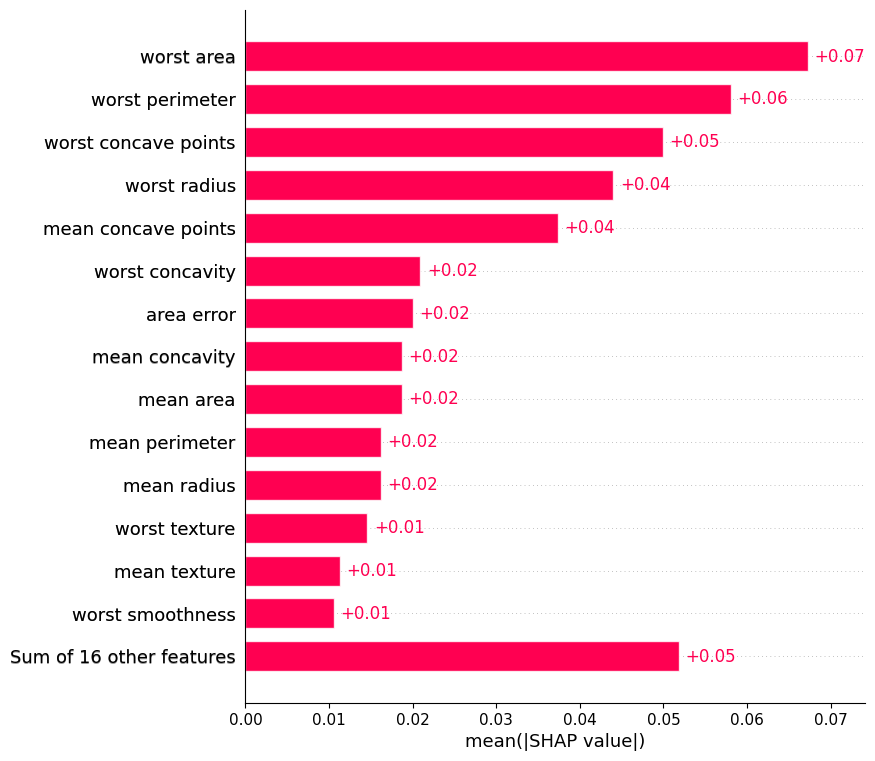

In [11]:
# Global feature importance (mean |SHAP|)
shap.plots.bar(sv_pos, max_display=15)


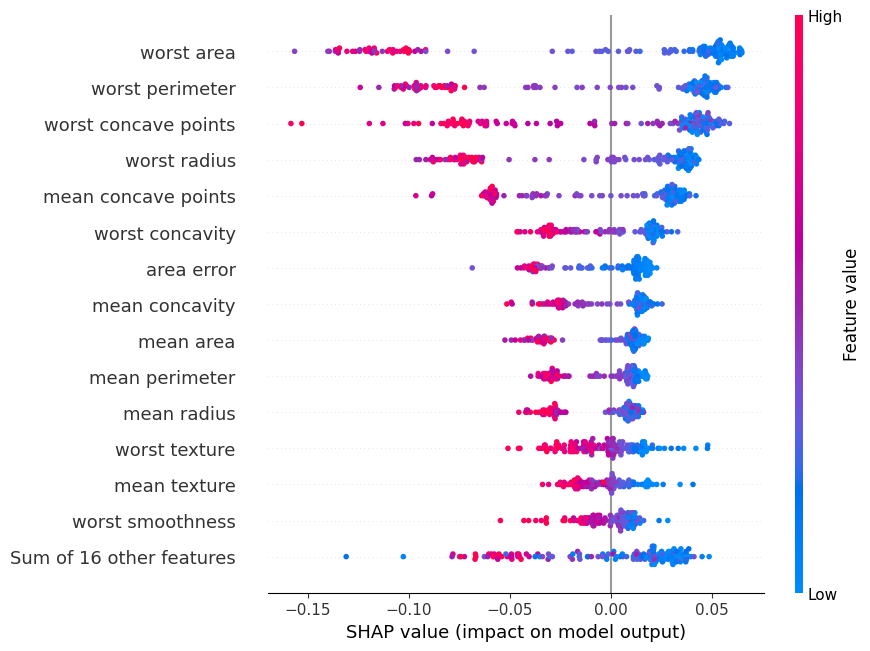

In [12]:
# Beeswarm: shows the distribution of SHAP values for each feature
# Each point is a sample; colour reflects feature value (low→high).
shap.plots.beeswarm(sv_pos, max_display=15)


### How to read a beeswarm plot

For each feature row:
- Points to the **right** increase the model output for the positive class.
- Points to the **left** decrease it.
- Colour indicates whether the feature value is low or high.

Example interpretation pattern:
- If high (red) values sit mostly on the right, higher feature values tend to increase predicted probability of the positive class.
- If high values sit on the left, higher feature values tend to reduce it.


### 7.2 Local explanation with SHAP: one prediction

We can explain a single prediction using a **waterfall plot**.
This shows:
- the baseline prediction (expected value)
- each feature’s contribution
- the final prediction for that instance

Let’s explain the same instance we used for LIME.


True label: malignant
Predicted probabilities: [1. 0.]


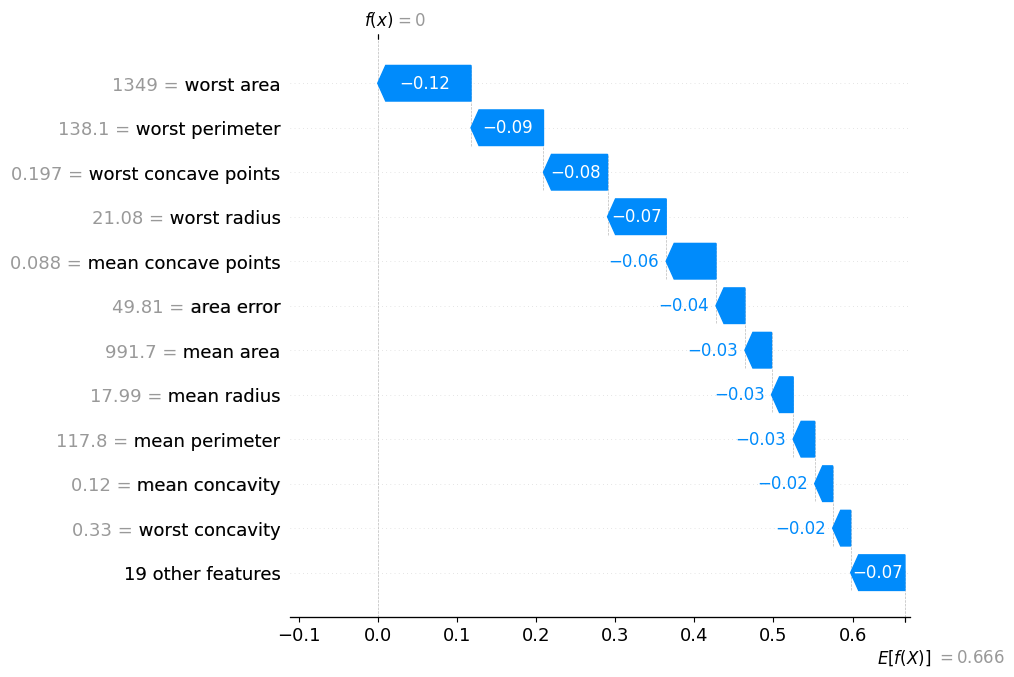

In [13]:
i = idx  # reuse the LIME index

print("True label:", class_names[int(y_test.iloc[i])])
print("Predicted probabilities:", rf.predict_proba(X_test.iloc[[i]])[0])

# Waterfall plot for a single instance
shap.plots.waterfall(sv_pos[i], max_display=12)


### Linking SHAP values to probabilities (conceptual note)

For many classifiers, SHAP explains the model output in a *link space* (often log-odds), not always probability directly.

That’s why:
- SHAP values add up nicely (good for attribution),
- but you should be careful interpreting “+0.2” as “+20% probability”.

In this notebook, focus on:
- **sign** (pushes prediction up vs down),
- **relative size** (bigger magnitude = bigger effect),
- **ranking** of important features.


<a id="lime-vs-shap"></a>
## 8) LIME vs SHAP: comparison

### Similarity
Both are **post-hoc** and often **model-agnostic** (you can use them on almost any model).

### Key differences

**LIME**
- Builds a *local surrogate model* via sampling + weighting
- Can be quick, but results may vary across runs
- No guarantee of fair attribution; depends on local fit quality

**SHAP**
- Aims for *fair additive attribution* (Shapley values)
- For tree models, can be fast and theoretically grounded
- For general black-box models (KernelSHAP), can be expensive

### A quick practical comparison for one instance
Let’s print the top features according to each method for the same `idx`.


In [14]:
# Top features from SHAP for one instance
shap_contrib = pd.Series(sv_pos[i].values, index=feature_names).sort_values(key=np.abs, ascending=False)
print("Top features by |SHAP| (single instance):")
print(shap_contrib.head(10))


Top features by |SHAP| (single instance):
worst area             -0.117853
worst perimeter        -0.091537
worst concave points   -0.080933
worst radius           -0.074102
mean concave points    -0.062933
area error             -0.036509
mean area              -0.033620
mean radius            -0.027339
mean perimeter         -0.027184
mean concavity         -0.022770
dtype: float64


In [15]:
# Top features from LIME for the same instance
print("Top features by LIME (single instance):")
for feat, weight in lime_exp.as_list()[:10]:
    print(f"{feat:40s}  {weight:+.4f}")


Top features by LIME (single instance):
worst area > 1034.25                      -0.1431
worst concave points > 0.16               -0.1092
worst perimeter > 124.97                  -0.1063
worst radius > 18.55                      -0.0954
mean concave points > 0.07                -0.0766
area error > 45.13                        -0.0656
mean area > 765.38                        -0.0482
mean perimeter > 103.67                   -0.0457
mean radius > 15.75                       -0.0395
worst compactness > 0.34                  -0.0167


You should expect **some overlap** but not necessarily an exact match, because:

- LIME fits a local surrogate (approximation error + sampling randomness)
- SHAP is additive attribution relative to a baseline distribution
- Both depend on choices (neighbourhood for LIME; background data for SHAP)

In real work, it's common to use multiple methods as “cross-checks”.


<a id="pitfalls"></a>
## 9) Pitfalls & good practice

Explainability tools are powerful, but easy to misuse. Here are common pitfalls:

### 1) Correlated features
If two features are strongly correlated, attribution becomes ambiguous:
- the model can “share” credit between them in different ways
- importance can depend heavily on the background data and perturbation strategy

**Good practice:** inspect correlations, consider grouping correlated features, and be cautious in conclusions.

### 2) Data leakage and spurious cues
Models can learn shortcuts (e.g., a feature that accidentally encodes the label).

**Good practice:** validate your features, do sanity checks, and use explanations to hunt for leakage.

### 3) Stability (especially for LIME)
LIME can give different explanations on different runs.

**Good practice:** run LIME multiple times, check whether top features are consistent.

### 4) Choice of background data (SHAP)
SHAP values depend on what “missing” means. Background data defines the reference.

**Good practice:** use a representative background sample; for sensitive tasks, justify your choice.

### 5) Explanations ≠ causation
An explanation says “the model used this feature”, not “this feature caused the outcome”.

**Good practice:** never claim causality from SHAP/LIME alone. For causal claims you need causal methods and study design.

### 6) Human factors
Explanations can be persuasive even when wrong.

**Good practice:** treat explanations as diagnostic evidence, not proof.


<a id="exercises"></a>
## 10) Exercises

Try these after you’ve run the notebook once.

### Conceptual questions (write short answers)

1. What is the difference between **global** and **local** explanations?
2. Why can **correlated features** make explanations ambiguous?
3. In your own words, what is the main idea behind LIME?
4. In your own words, what is the main idea behind SHAP / Shapley values?
5. Give one reason why LIME explanations might change across runs.
6. Why is it risky to interpret SHAP/LIME explanations as **causal**?

---

### Coding exercises (hands-on)

#### Exercise A: Explain multiple instances
1. Pick **5 different** test instances (vary indices).
2. For each instance:
   - show the LIME plot
   - show the SHAP waterfall plot
3. Do you see consistent patterns? Where do they disagree?

*Hint:* wrap the explanation code in a loop.

#### Exercise B: LIME stability check
1. Choose one instance `idx`.
2. Run LIME **5 times** with different random seeds or with different `num_samples`.
3. Record the top 5 features each time.
4. Are they stable?

*Extension:* compute the overlap between top-5 sets.

#### Exercise C: Effect of SHAP background choice
1. Compute SHAP values with `background = shap.sample(X_train, 50, random_state=...)`
2. Compute again with `background = shap.sample(X_train, 500, random_state=...)`
3. Compare:
   - global bar plots
   - local waterfall plot for one instance

What changes? Why might that happen?

#### Exercise D: Debug a misclassification
1. Find an instance where the model prediction is wrong:
   - `y_test != rf.predict(X_test)`
2. Explain it with SHAP and LIME.
3. Based on explanations, propose a hypothesis for why the model got it wrong.
4. (Optional) What extra data or features might help?

---

### Discussion prompt (for group work)
“Explainability improves trust.”

Do you agree? Under what conditions might explainability *reduce* trust?


<a id="mini-project"></a>
## 11) Mini-project (optional): regression example (California housing)

If you want extra practice, try SHAP + LIME on a regression task.

Goal: predict median house value from features.

You can:
- train a `RandomForestRegressor`
- use `LimeTabularExplainer(mode="regression")`
- use `shap.TreeExplainer` again

This section is optional and includes starter code.


In [16]:
# OPTIONAL: run this section if you want a regression mini-project
from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

housing = fetch_california_housing(as_frame=True)
Xh = housing.data
yh = housing.target

Xh_train, Xh_test, yh_train, yh_test = train_test_split(
    Xh, yh, test_size=0.25, random_state=RANDOM_STATE
)

rfr = RandomForestRegressor(n_estimators=400, random_state=RANDOM_STATE, n_jobs=-1)
rfr.fit(Xh_train, yh_train)

yh_pred = rfr.predict(Xh_test)
print(f"MAE: {mean_absolute_error(yh_test, yh_pred):.3f}")
print(f"R²:  {r2_score(yh_test, yh_pred):.3f}")


MAE: 0.327
R²:  0.810


In [ ]:
# OPTIONAL: SHAP for regression
background_h = shap.sample(Xh_train, 200, random_state=RANDOM_STATE)
explainer_h = shap.TreeExplainer(rfr, data=background_h)
sv_h = explainer_h(Xh_test)

shap.plots.bar(sv_h, max_display=15)


 45%|=========           | 2310/5160 [22:51<28:11]       

In [ ]:
# OPTIONAL: LIME for regression
lime_reg = LimeTabularExplainer(
    training_data=Xh_train.values,
    feature_names=Xh_train.columns.tolist(),
    mode="regression",
    discretize_continuous=True,
    random_state=RANDOM_STATE
)

j = 0
exp_reg = lime_reg.explain_instance(
    data_row=Xh_test.iloc[j].values,
    predict_fn=rfr.predict,
    num_features=10,
    num_samples=5000
)

print("True value:", float(yh_test.iloc[j]))
print("Predicted :", float(rfr.predict(Xh_test.iloc[[j]])[0]))
fig = exp_reg.as_pyplot_figure()
plt.title("LIME local explanation (regression)")
plt.show()


## Wrap-up

You should now be able to:
- explain the difference between global and local explanations
- generate LIME explanations for individual predictions
- generate SHAP explanations and interpret global + local plots
- recognise common pitfalls (correlation, stability, background choice, non-causality)

If you want, tell me:
- what subject your students are in (CS, business, biology, etc.)
- how long the lab session is
…and I can tailor the notebook further (more/less depth, more exercises, or a domain-specific dataset).
